In [36]:
from sklearn.cluster import AgglomerativeClustering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from libpysal.weights import Queen, KNN

import ipdb

C:\Users\10169\anaconda3\lib\site-packages\libpysal\weights\util.py:23: UserWarning: geopandas not available. Some functionality will be disabled.
  warn("geopandas not available. Some functionality will be disabled.")


In [37]:
nodes = pd.read_csv('Proj_Data/node.csv', index_col=0)
edges = pd.read_csv('Proj_Data/edges_with_qkv.csv', index_col=0)
nodes['index 2'] = nodes.index

# relation_df = edges[['node1', 'node2', 'q']].copy()
# relation = np.array(relation_df)

# G = nx.Graph()
# G.add_nodes_from(np.array(nodes.index))
# G.add_weighted_edges_from(relation)  # add weight from flow

# print('There are %d nodes.' % G.number_of_nodes())
# print('There are %d edges.' % G.number_of_edges())

In [39]:
# Set seed for reproducibility
np.random.seed(0)
# Iniciate the algorithm
model = AgglomerativeClustering(linkage='ward', n_clusters=4)
# Run clustering
model.fit(nodes['q'])
# Assign labels to main data table
nodes['cls'] = model.labels_

In [40]:
nodes

,index,ID,q,k,v,Long,Lat,index 2,cls
0,0,715898,410.684028,0.090358,62.457812,-118.021787,33.880183,0,2
1,3,715929,405.503472,0.154721,54.573437,-118.123095,33.971707,1,2
2,5,715933,383.663194,0.131772,56.324479,-118.130679,33.981839,2,0
3,6,715938,393.451389,0.137075,54.980208,-118.150997,34.002541,3,0
4,7,715944,381.265625,0.151283,56.689583,-118.166091,34.013676,4,0
...,...,...,...,...,...,...,...,...,...
1316,1863,776457,308.024306,0.048418,68.017014,-118.712596,34.140004,1316,0
1317,1864,776465,252.569444,0.050435,66.585069,-118.865433,34.176675,1317,1
1318,1865,776480,318.086806,0.165058,53.344792,-118.231606,34.053569,1318,0
1319,1866,776487,314.135417,0.066274,64.290278,-117.997784,34.079858,1319,0


In [43]:
w = Queen.from_dataframe(nodes[['q']])

AttributeError: 'DataFrame' object has no attribute 'geometry'

In [ ]:
data_new = pd.read_csv('./Proj_Data/2019-10-21_with_cord.csv', index_col=0)
data_new = data_new.loc[data_new['Lane type']=='ML']

data_new['cls'] = ''
for i in nodes.index:
    ID = nodes.loc[i, 'ID']
    cls = nodes.loc[i, 'cls']
    data_new.loc[data_new['ID']==ID, 'cls'] = cls
data_new['q0'] = data_new['q'] * 12
data_new['k0'] = data_new['q0'] / data_new['Avg v']

There are 4 classes


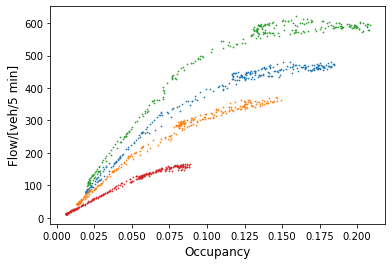

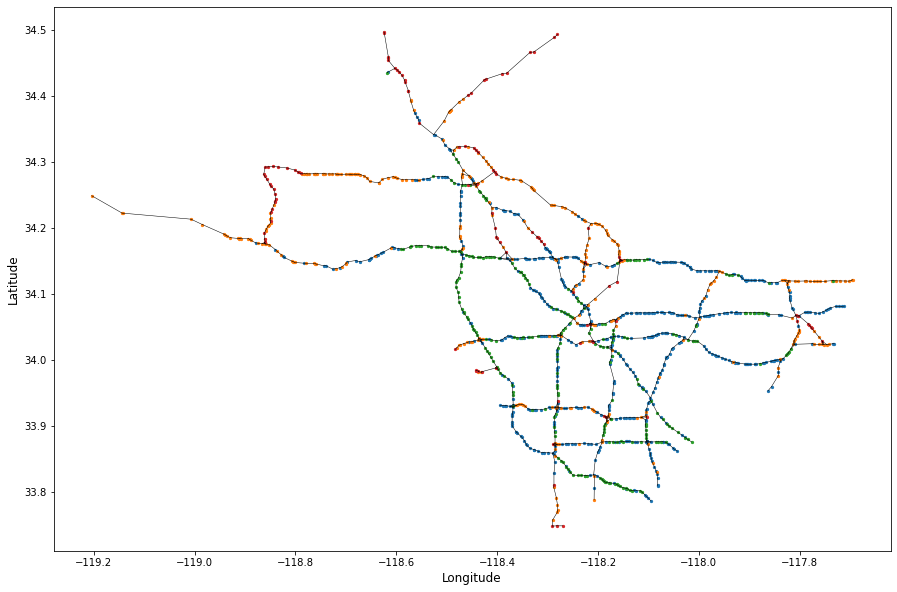

In [41]:
c = 0
c_set = []
color_set = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig_mfd = plt.figure()
ax_mfd = fig_mfd.add_subplot(111)
fig_net = plt.figure(figsize=[15,10])
ax_net = fig_net.add_subplot(111)

for i in edges.index:
    node1 = edges.loc[i, 'node1']
    node2 = edges.loc[i, 'node2']
    ax_net.plot([nodes.loc[node1, 'Long'], nodes.loc[node2, 'Long']], [nodes.loc[node1, 'Lat'], nodes.loc[node2, 'Lat']], 'black', lw=0.5)

for i in range(len(nodes['cls'].drop_duplicates())):
    data_cls = data_new.loc[data_new['cls']==i].sort_values(by=['ID', 'Time'])
    q_cls = data_cls['q'].values
    if q_cls.reshape(-1, 288).shape[0] <= 1:
        continue
    q_cls_avg = q_cls.reshape(-1, 288).mean(axis=0)
    k_cls = data_cls['Avg k'].values
    k_cls_avg = k_cls.reshape(-1, 288).mean(axis=0)
    ax_mfd.scatter(k_cls_avg, q_cls_avg, s=.5, c=color_set[c])
    ax_mfd.set_xlabel('Occupancy', fontsize=12)
    ax_mfd.set_ylabel('Flow/[veh/5 min]', fontsize=12)
    
    lng = nodes.loc[nodes['cls']==i, 'Long']
    lat = nodes.loc[nodes['cls']==i, 'Lat']
    ax_net.scatter(lng, lat, s=5, c=color_set[c])
    ax_net.set_xlabel('Longitude', fontsize=12)
    ax_net.set_ylabel('Latitude', fontsize=12)
    c+=1
    c_set.append(i)

    
print('There are %i classes'%c)
# fig_mfd.savefig('./img/fig_mfd.png', dpi=500)
# fig_net.savefig('./img/fig_net.png', dpi=500)

# Example from sklearn doc

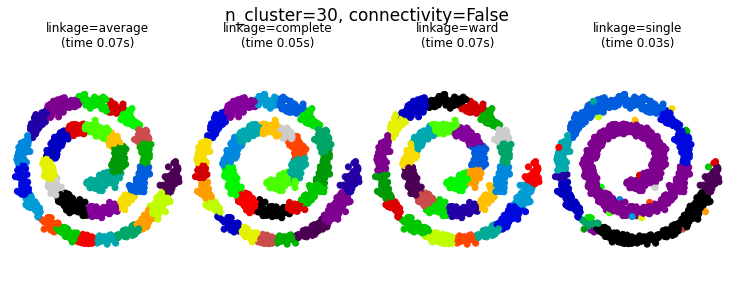

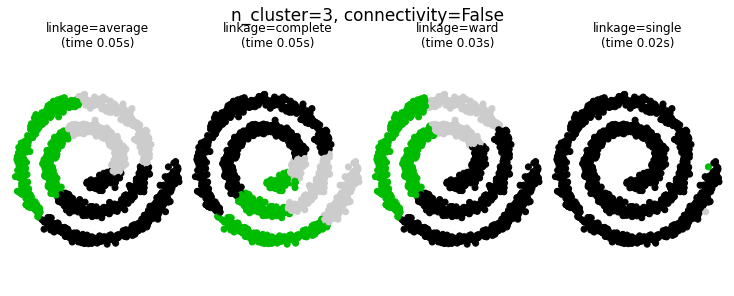

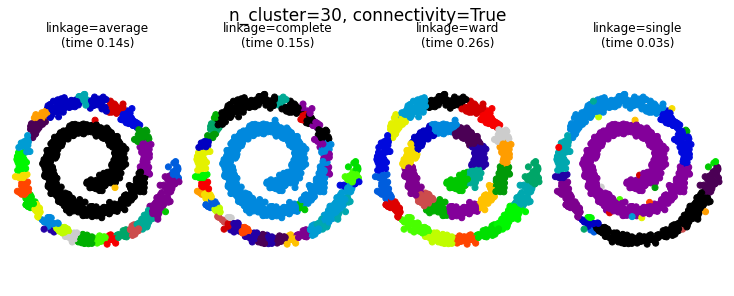

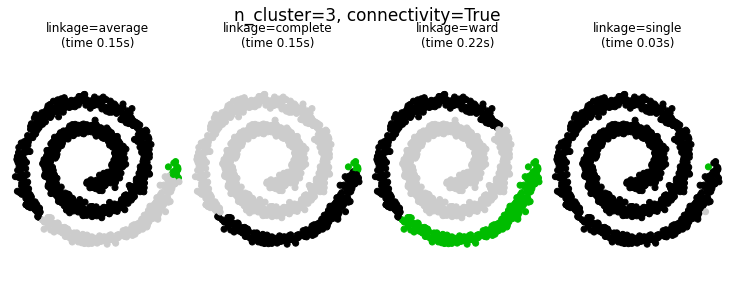

In [15]:
# Authors: Gael Varoquaux, Nelle Varoquaux
# License: BSD 3 clause

import time
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

# Generate sample data
n_samples = 1500
np.random.seed(0)
t = 1.5 * np.pi * (1 + 3 * np.random.rand(1, n_samples))
x = t * np.cos(t)
y = t * np.sin(t)


X = np.concatenate((x, y))
X += 0.7 * np.random.randn(2, n_samples)
X = X.T

# Create a graph capturing local connectivity. Larger number of neighbors
# will give more homogeneous clusters to the cost of computation
# time. A very large number of neighbors gives more evenly distributed
# cluster sizes, but may not impose the local manifold structure of
# the data
knn_graph = kneighbors_graph(X, 30, include_self=False)

for connectivity in (None, knn_graph):
    for n_clusters in (30, 3):
        plt.figure(figsize=(10, 4))
        for index, linkage in enumerate(("average", "complete", "ward", "single")):
            plt.subplot(1, 4, index + 1)
            model = AgglomerativeClustering(
                linkage=linkage, connectivity=connectivity, n_clusters=n_clusters
            )
            t0 = time.time()
            model.fit(X)
            elapsed_time = time.time() - t0
            plt.scatter(X[:, 0], X[:, 1], c=model.labels_, cmap=plt.cm.nipy_spectral)
            plt.title(
                "linkage=%s\n(time %.2fs)" % (linkage, elapsed_time),
                fontdict=dict(verticalalignment="top"),
            )
            plt.axis("equal")
            plt.axis("off")

            plt.subplots_adjust(bottom=0, top=0.83, wspace=0, left=0, right=1)
            plt.suptitle(
                "n_cluster=%i, connectivity=%r"
                % (n_clusters, connectivity is not None),
                size=17,
            )


plt.show()